In [1]:
import os
from pathlib import Path

import torch
from torch import optim
from torch.utils import data
from torchvision import transforms, datasets
from torchvision.utils import save_image

from lib.loss_vae import VAELoss
from lib.model_vae import VAE

from lib.train_vae import setup_mnist_dataloader

from matplotlib import pyplot as plt

In [2]:
# setup dataloader
train_loader, test_loader = setup_mnist_dataloader()

In [3]:
def train_vae(
    train_loader: data.DataLoader,
    test_loader: data.DataLoader,
    num_epochs: int = 15,
    lr: float = 1e-3,
    kl_loss_weight: float = 1.0,
    save_images: bool = True,
    device: str = "cuda",
    output_dir: str = "results",
):
    model = VAE()
    model = model.to(device)
    output_dir = Path(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = VAELoss(kl_loss_weight=kl_loss_weight)
    reconstructed_batch_pre = None
    for epoch in range(num_epochs):
        # train
        model.train()
        train_loss = 0
        for batch_idx, (image, _label) in enumerate(train_loader):
            image = image.to(device)
            optimizer.zero_grad()
            reconstructed_batch, mu, logvar = model(image)
            loss = loss_fn(reconstructed_batch, image, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            # save first 8 training images only in the first epoch
            if save_images and batch_idx == 0 and epoch == 0:
                n = min(image.shape[0], 8)
                training_image = image[:n].view(
                    image[:n].shape[0] * image[:n].shape[1],
                    image[:n].shape[2],
                    image[:n].shape[3],
                )
                training_image = torch.hstack(list(training_image))
                plt.imshow(training_image.cpu().detach())
                plt.show()
        print(
            f"Epoch: {epoch + 1:3d} / {num_epochs:3d} Average train set loss: "
            f"{train_loss / len(train_loader.dataset):.4f}"
        )

        # test
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_idx, (image, _label) in enumerate(test_loader):
                image = image.to(device)
                reconstructed_batch, mu, logvar = model(image)
                test_loss += loss_fn(reconstructed_batch, image, mu, logvar).item()

                # save first 8 test images and their reconstructions
                if save_images and batch_idx == 0:
                    n = min(image.shape[0], 8)
                    comparison = torch.cat([image[:n], reconstructed_batch[:n]])


                    training_image1 = image[:n].view(
                        image[:n].shape[0] * image[:n].shape[1],
                        image[:n].shape[2],
                        image[:n].shape[3],
                    )
                    training_image1 = torch.hstack(list(training_image1))
                    
                    training_image2 = reconstructed_batch[:n].view(
                        reconstructed_batch[:n].shape[0] * reconstructed_batch[:n].shape[1],
                        reconstructed_batch[:n].shape[2],
                        reconstructed_batch[:n].shape[3],
                    )
                    training_image2 = torch.hstack(list(training_image2))
                    
                    comparison = torch.vstack([training_image1, training_image2])
                    plt.imshow(comparison.cpu().detach())
                    # if reconstructed_batch_pre != None:
                    #     diff = (training_image2-reconstructed_batch_pre).abs()
                    #     plt.imshow(diff.cpu().detach())
                    #     plt.colorbar()

                    plt.show()
                    # reconstructed_batch_pre = training_image2.clone()
        test_loss /= len(test_loader.dataset)
        print(f"Average test set loss: {test_loss:.4f}")

    # save model for later plotting
    model_file = output_dir / f"model.pth"
    torch.save(model.state_dict(), model_file)
    print(f"Saved model to {model_file}")

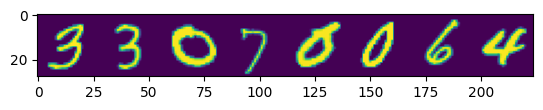

Epoch:   1 /  15 Average train set loss: 249.4545


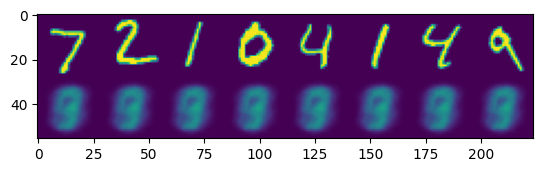

Average test set loss: 206.7224
Epoch:   2 /  15 Average train set loss: 206.6940


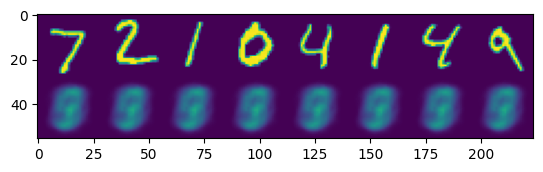

Average test set loss: 206.6324
Epoch:   3 /  15 Average train set loss: 206.5797


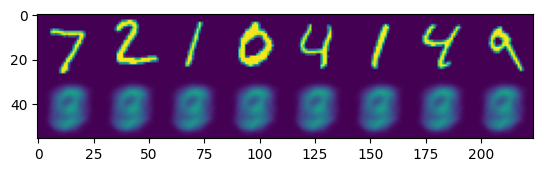

Average test set loss: 206.4594
Epoch:   4 /  15 Average train set loss: 206.4791


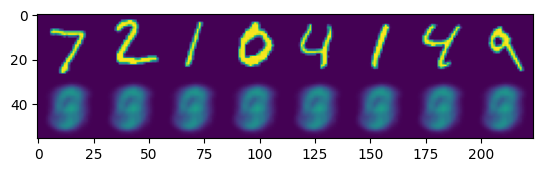

Average test set loss: 206.0526
Epoch:   5 /  15 Average train set loss: 206.4592


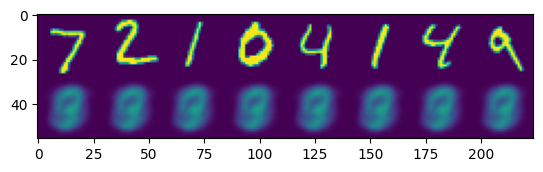

Average test set loss: 206.1916
Epoch:   6 /  15 Average train set loss: 206.4020


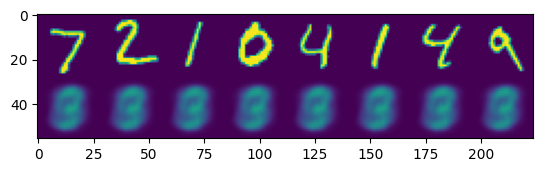

Average test set loss: 206.0815
Epoch:   7 /  15 Average train set loss: 206.3707


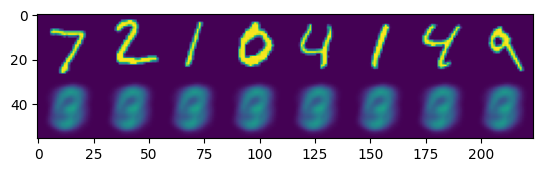

Average test set loss: 205.9949
Epoch:   8 /  15 Average train set loss: 206.3231


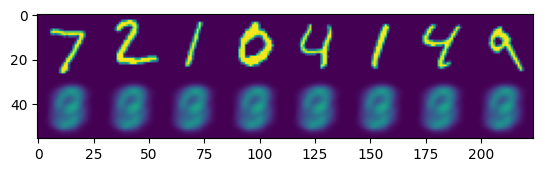

Average test set loss: 205.9922
Epoch:   9 /  15 Average train set loss: 206.3181


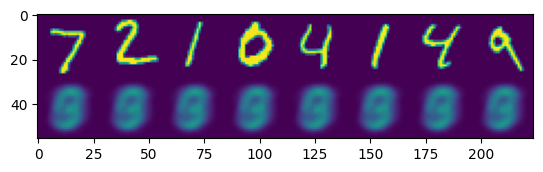

Average test set loss: 206.0221
Epoch:  10 /  15 Average train set loss: 206.3552


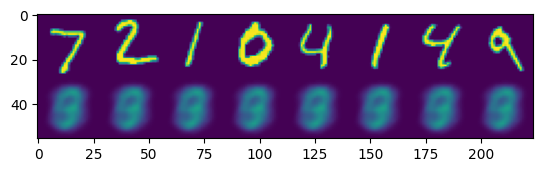

Average test set loss: 206.1371
Epoch:  11 /  15 Average train set loss: 206.3253


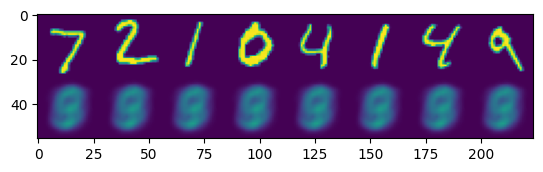

Average test set loss: 206.1026
Epoch:  12 /  15 Average train set loss: 206.3208


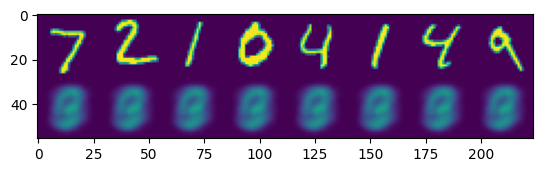

Average test set loss: 205.9698
Epoch:  13 /  15 Average train set loss: 206.3333


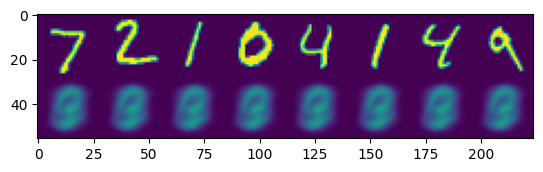

Average test set loss: 206.0509
Epoch:  14 /  15 Average train set loss: 206.3443


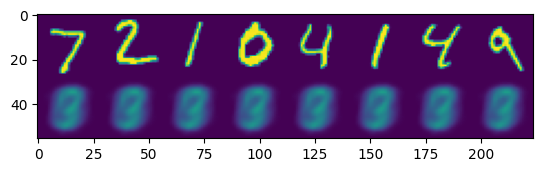

Average test set loss: 206.1945
Epoch:  15 /  15 Average train set loss: 206.3378


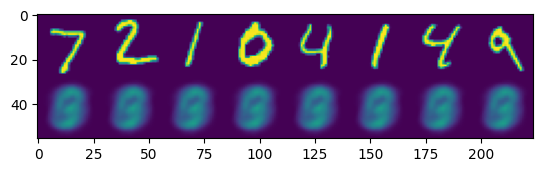

Average test set loss: 206.1692
Saved model to results/model.pth


In [4]:
train_vae(train_loader, test_loader, lr=0.1)